## This script is used to generate plots related.

In [1]:
# import packages
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# define the repository path
from common_settings import  obspath, outpath, events_name, \
    obs_events, day_load_flow, hour_load_flow, conct_name, modpath, mod_load_flow

from utils.plotting import cq_line_plot
from utils.concentration import cumulative_lq, excel_save
from utils.signatures import update_cumul_df, load_flow_loc

### The double-mass plot of flow and loads

In [2]:
def double_mass_line(df, xycols, fs, xlabel, ylabel, color=None, legd=None, ls=None, ax=None):
    ax = df.plot(x=xycols[0], y= xycols[1], ax=ax, ls=ls, color=color)
    ax.set_xlabel(xlabel, fontsize=fs)
    ax.set_ylabel(ylabel, fontsize=fs)
    return ax

In [3]:
fn_day = 'obs_year_cumulative_ratio_day'
df_day = pd.read_excel(f'{outpath}{fn_day}.xlsx', sheet_name=[f'obs_year_{i}' for i in range(9)]);

In [4]:
fn_hour = 'obs_year_cumulative_ratio_hour'
df_hour = pd.read_excel(f'{outpath}{fn_hour}.xlsx', None);

In [5]:
fn_mod = 'mod_year_cumulative_ratio_day'
df_mod = pd.read_excel(f'{outpath}{fn_mod}.xlsx', None);

In [9]:
# read inputs (*cumulative_ratio*.xlsx)
xylabel = ['cumul_flow_ratio', 'cumul_load_ratio']
xlabel='Normalized cumulative flow volume'
ylabel='Normalized cumulative mass'
fs=20; fs_legd = 16

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


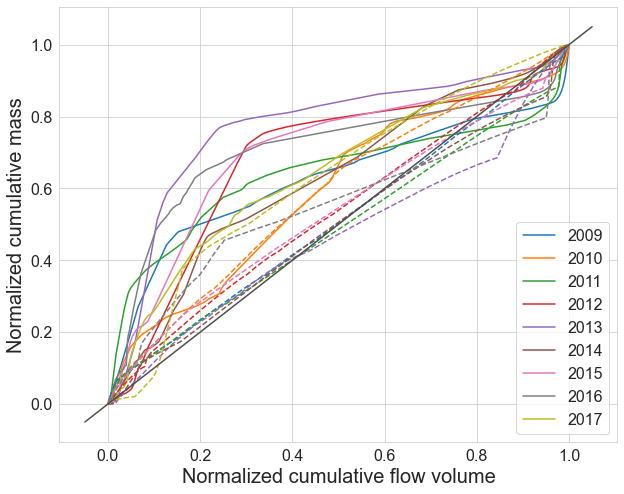

In [11]:
sns.set_style('whitegrid')
sns.color_palette("tab10")
# sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})
plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
legd = []
colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
ii = 0
for _, val in df_day.items():
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, colors[ii], legd, ax=ax)
    ii += 1
# for _, val in df_hour.items():
#     legd.append(str(val.values[0][0])[0:4])
#     double_mass_line(val, xylabel, fs, xlabel, ylabel, legd, ax=ax, ls='-.')
ii = 0
for _, val in df_mod.items():    
    legd.append(str(val.values[0][0])[0:4])
    double_mass_line(val, xylabel, fs, xlabel, ylabel, colors[ii], legd, ax=ax, ls='--')
    ii += 1
ax.legend(legd[0:9], fontsize=fs_legd);
ax.plot(ax.get_xlim(), ax.get_xlim(), c=".3")
ax.set_yticklabels(np.round(ax.get_yticks(), 2), size = 16);
ax.set_xticklabels(np.round(ax.get_xticks(), 2), size = 16);
plt.savefig(f'{outpath}figs/{fn_day}.png', format='png', dpi=400)

### Plot Event Mean Concentration (EMC)

In [36]:
# import EMC and tranform into a matrix
emc = pd.read_csv(f'{outpath}obs_storm_event_common2.csv', index_col='ID')
emc_mod = pd.read_csv(f'{outpath}DIN_mod_storm_event_common2.csv', index_col='ID')

In [37]:
emc_matrix = {year: [] for year in range(2009, 2018)}
emc_mod_matrix = {year: [] for year in range(2009, 2018)}
# emc_matrix = {year: [] for year in range(2009, 2014)}
emc.start = pd.to_datetime(emc.start)
emc_mod.start = pd.to_datetime(emc_mod.start)

In [4]:
col_plt = ['event_load_coefficients', 'emc(mg/l)'][1]
fig_names = ['event_load_coefficients', 'emc'][1]
for ii in emc.index:
    if emc.start[ii].month < 7:
        emc_matrix[emc.start[ii].year - 1].append(emc.loc[ii, col_plt]) #event_load_coefficients
    else:
        emc_matrix[emc.start[ii].year].append(emc.loc[ii, col_plt])
# convert dict into a dataframe
df_fillna = pd.DataFrame(index=np.arange(1, 15), columns=emc_matrix.keys())
mod_df_fillna = pd.DataFrame(index=np.arange(1, 15), columns=emc_matrix.keys())
for key, val in emc_matrix.items():
    df_fillna.loc[0:len(val), key] = val
    
df_fillna.fillna(0, inplace=True)
# creat a mask
mask = np.zeros_like(df_fillna.values)
mask[df_fillna == 0] = True

# For mod    
for ii in emc_mod.index:
    if emc_mod.start[ii].month < 7:
        emc_mod_matrix[emc_mod.start[ii].year - 1].append(emc_mod.loc[ii, col_plt])
    else:
        emc_mod_matrix[emc_mod.start[ii].year].append(emc_mod.loc[ii, col_plt])
        
for key, val in emc_mod_matrix.items():
    mod_df_fillna.loc[0:len(val), key] = val

mod_df_fillna.fillna(0, inplace=True)
# creat a mask
mod_mask = np.zeros_like(mod_df_fillna.values)
mod_mask[mod_df_fillna == 0] = True

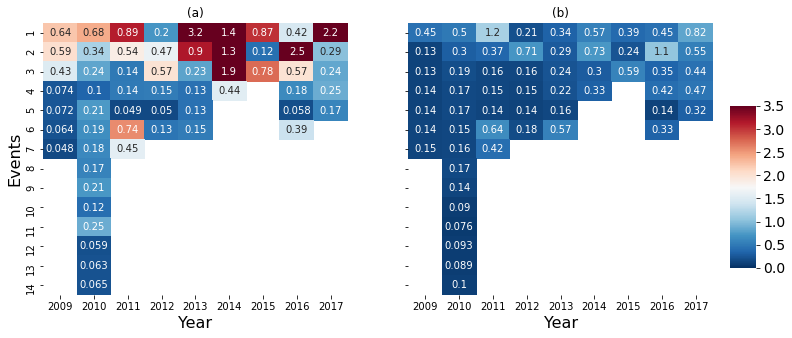

In [10]:
# sns.set_context({"figure.figsize":(17,5)})
sns.axes_style("white")
fig,axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
cbar_ax = fig.add_axes([.92, .2, .03, .45])
ax = sns.heatmap(data=np.array(df_fillna.values), annot=True, mask=mask, vmin=0, vmax=1,
            xticklabels=df_fillna.columns, yticklabels= df_fillna.index,cmap="RdBu_r", ax=axes[0], cbar=0)
ax1 = sns.heatmap(data=np.array(mod_df_fillna.values), annot=True, mask=mod_mask, vmin=0, vmax=3.5,
            xticklabels=mod_df_fillna.columns, yticklabels= mod_df_fillna.index,cmap="RdBu_r", ax=axes[1], cbar_ax=cbar_ax)
ax.set_title('(a)')
ax1.set_title('(b)')
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Events', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14);
plt.savefig(f'{outpath}figs/obs_mod_{fig_names}_common2.png', format='png', dpi=400)

### Calculate the correlation coefficient between observed and modeled data.

In [46]:
from scipy.stats import pearsonr
prs = pearsonr(emc['event_load_coefficients'], emc_mod['event_load_coefficients'])
prs

(0.5101936956159734, 4.291010627959809e-05)

## The seasonal correlation between concentration and discharge

In [21]:
time_ranges = [[f'{year}/7/1', f'{year}/10/1', f'{year+1}/1/1', f'{year+1}/4/1', f'{year+1}/7/1'] for year in range(2009, 2018)]
df_ratio = pd.DataFrame(index=[str(year) for year in range(2009, 2018)], columns = [1, 2, 3, 4])
cols = mod_load_flow.columns # mod_load_flow, day_load_flow
# day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000

In [4]:
cols

Index(['Loads (kg)', 'Downstream Flow Concentration (mg.L^-1)',
       'Flow_cumecs (ML.day^-1)'],
      dtype='object')

In [23]:
# 大论文意见校正
from scipy.stats import kendalltau
for ii in range(1,2):
    x, y = np.array([]), np.array([])
    for tt in time_ranges:
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], mod_load_flow, timestep ='d')
        df_sum = df.sum(axis=0)
        y = df[cols[1]].values
        x = df[cols[2]].values
    # Calculate the pearson correlation
        kr = kendalltau(x, y)
        print("Kendall 相关系数： ", kr)
        print('Average conc.=', y.mean())

Kendall 相关系数：  KendalltauResult(correlation=0.9751552795031055, pvalue=3.9829518885504735e-43)
Average conc.= 0.3573671791521738
Kendall 相关系数：  KendalltauResult(correlation=-0.5059722885809842, pvalue=9.092242798195073e-13)
Average conc.= 0.8362866150543479
Kendall 相关系数：  KendalltauResult(correlation=0.8471094123268036, pvalue=5.7594530607221305e-33)
Average conc.= 0.39482723689130433
Kendall 相关系数：  KendalltauResult(correlation=0.7625418060200668, pvalue=4.982783056460885e-27)
Average conc.= 0.37353122184782606
Kendall 相关系数：  KendalltauResult(correlation=0.7926421404682275, pvalue=4.515473548420641e-29)
Average conc.= 0.22399045251086958
Kendall 相关系数：  KendalltauResult(correlation=0.8604873387482083, pvalue=5.819250779249453e-34)
Average conc.= 0.616933100326087
Kendall 相关系数：  KendalltauResult(correlation=0.8686096512183469, pvalue=1.422126794270141e-34)
Average conc.= 0.7531986621847825
Kendall 相关系数：  KendalltauResult(correlation=0.0989010989010989, pvalue=0.1626122280691461)
Average 

In [24]:
# 大论文意见校正
from scipy.stats import kendalltau
time_ranges = [[f'{year}/7/1', f'{year}/10/1', f'{year+1}/1/1', f'{year+1}/4/1', f'{year+1}/7/1'] for year in range(2009, 2018)]
df_ratio = pd.DataFrame(index=[str(year) for year in range(2009, 2018)], columns = [1, 2, 3, 4])
cols = day_load_flow.columns # mod_load_flow, day_load_flow
# day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000
for ii in range(1, 2):
    x, y = np.array([]), np.array([])
    for tt in time_ranges:
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], day_load_flow, timestep ='d')
        df_sum = df.sum(axis=0)
        y = df[cols[-1]].values
        x = df[cols[2]].values
    # Calculate the pearson correlation
        kr = kendalltau(x, y)
        print("Kendall 相关系数： ", kr)
        print('Average conc.=', y.mean())

Kendall 相关系数：  KendalltauResult(correlation=-0.01625627958121691, pvalue=0.8185904382378765)
Average conc.= 0.30508124128260866
Kendall 相关系数：  KendalltauResult(correlation=-0.5613951266125179, pvalue=2.2616688698412943e-15)
Average conc.= 0.46054489348913047
Kendall 相关系数：  KendalltauResult(correlation=0.5083044895823451, pvalue=7.280008054736556e-13)
Average conc.= 0.8167288539891303
Kendall 相关系数：  KendalltauResult(correlation=0.4108017948246597, pvalue=6.713279727817212e-09)
Average conc.= 0.521180802902174
Kendall 相关系数：  KendalltauResult(correlation=0.4707712347672595, pvalue=3.1090746173614745e-11)
Average conc.= 0.8860743597826086
Kendall 相关系数：  KendalltauResult(correlation=0.39732259799974273, pvalue=2.0728549687396742e-08)
Average conc.= 0.6608193068369564
Kendall 相关系数：  KendalltauResult(correlation=0.47843030640638207, pvalue=1.65118059578205e-11)
Average conc.= 0.35133709281521736
Kendall 相关系数：  KendalltauResult(correlation=0.5218119731765952, pvalue=1.7973844333435594e-13)
Ave

In [5]:
# 大论文意见校正
for ii in range(4):
    x, y = np.array([]), np.array([])
    for tt in time_ranges:
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], mod_load_flow, timestep ='d')
        df_sum = df.sum(axis=0)
        try:
            y = np.append(y, df[cols[1]].values)
            x = np.append(x, df[cols[2]].values)
        except NameError:
            y = df[cols[1]].values
            x = df[cols[2]].values
    # Calculate the pearson correlation
    from scipy.stats import pearsonr
    pr = pearsonr(x, y)
    pr_log = pearsonr(np.log(x), np.log(y))
    from scipy.stats import kendalltau
    kr = kendalltau(x, y)
    kr_log = kendalltau(np.log(x), np.log(y))
    print("皮尔逊相关系数： ", pr)
    print("皮尔逊相关系数-log： ", pr_log)
    print("Kendall 相关系数： ", kr)
    print("Kendall 相关系数_log： ", kr_log)

皮尔逊相关系数：  (0.031944248559761024, 0.3585973699591191)
皮尔逊相关系数-log：  (0.41246574344176534, 2.3823200397533558e-35)
Kendall 相关系数：  KendalltauResult(correlation=0.3355647851205393, pvalue=2.3910432193755433e-47)
Kendall 相关系数_log：  KendalltauResult(correlation=0.3355647851205393, pvalue=2.3910432193755433e-47)
皮尔逊相关系数：  (-0.09851016890553739, 0.004550391488969081)
皮尔逊相关系数-log：  (0.3858914582899005, 8.576590317339078e-31)
Kendall 相关系数：  KendalltauResult(correlation=0.3864033319897891, pvalue=3.404436820425319e-62)
Kendall 相关系数_log：  KendalltauResult(correlation=0.3864033319897891, pvalue=3.404436820425319e-62)
皮尔逊相关系数：  (-0.13187213737706716, 0.00016425923414673476)
皮尔逊相关系数-log：  (-0.6086743312765402, 1.8192568580725308e-83)
Kendall 相关系数：  KendalltauResult(correlation=-0.3859189834358847, pvalue=7.107963381781435e-61)
Kendall 相关系数_log：  KendalltauResult(correlation=-0.3859189834358847, pvalue=7.107963381781435e-61)
皮尔逊相关系数：  (-0.049073122449862186, 0.16059187963868737)
皮尔逊相关系数-log：  (-0.0744

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


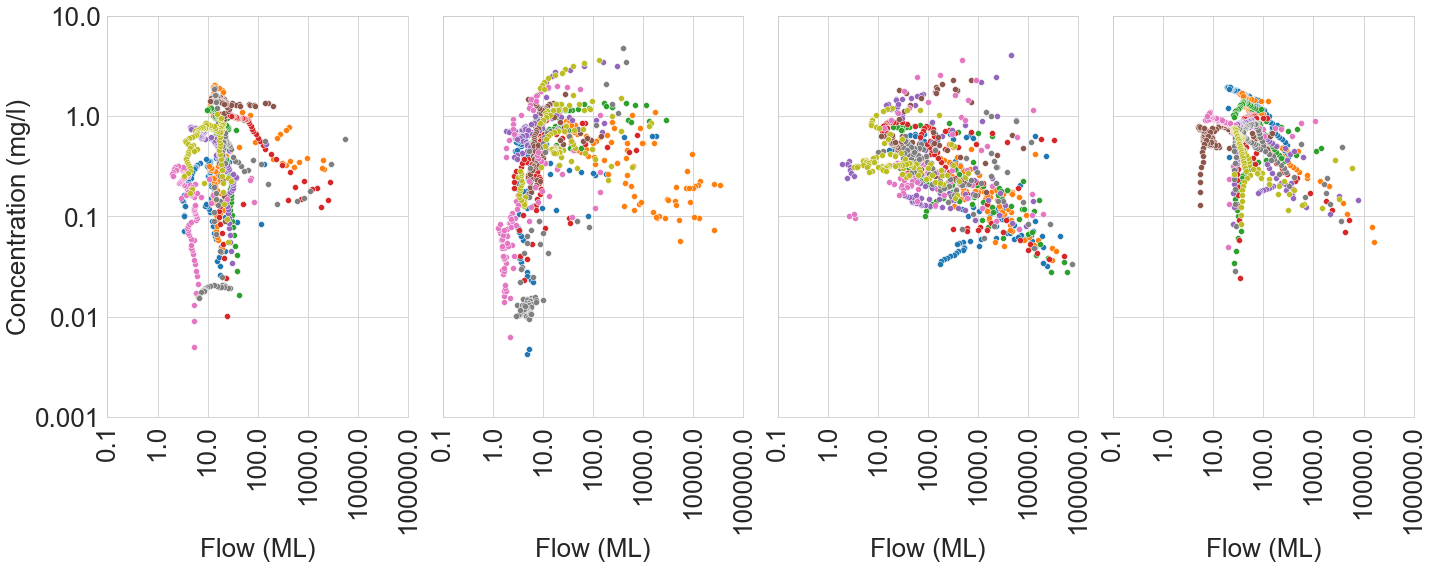

In [3]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 4, figsize=(20, 8), sharex=True, sharey=True)
for tt in time_ranges:
    for ii in range(len(tt) -1):
        start = pd.to_datetime(tt[ii])
        end = pd.to_datetime(tt[ii + 1]) - datetime.timedelta(days=1)   
        df = load_flow_loc([start, end], day_load_flow, timestep ='d')
        df_sum = df.sum(axis=0)
        sns.scatterplot(data=df, x=cols[2], y=cols[-1], ax=axes[ii])
for ax in axes:
    ax.set(xscale="log", yscale="log")
    ax.set_xticklabels(ax.get_xticks(), fontsize=26, rotation=90)
    ax.set_yticklabels(ax.get_yticks(), fontsize=26)
    ax.set_xlabel('Flow (ML)', fontsize=26)
    ax.set_xlim(0.1, 1e5)
    ax.set_ylim(0.001, 1e1)
axes[0].set_ylabel('Concentration (mg/l)', fontsize=26); #Load (kg) Concentration (mg/l)
# plt.legend(df_ratio.index, fontsize=24);
plt.tight_layout()
# plt.savefig(f'{outpath}figs/mod_season_concentration_flow.png', format='png', dpi=300)

## Plot month summarized metrics

In [2]:
df_month = pd.read_csv(f'{outpath}mod_obs_annual.csv', index_col = 'Year')
df_month = df_month / 1000
df_month['bias'] = np.round((1- np.abs(df_month['obs'] - df_month['mod']) / df_month['obs']), 2)

In [35]:
import plotly.graph_objects as go
import plotly.offline as py
import plotly
import plotly.io as pio
#setting offilne
plotly.offline.init_notebook_mode(connected=True)
trace0 = go.Bar(
    x = df_month.index,
    y = df_month['obs'].values,
    name = 'Measurement',
    marker = dict(
        color = 'rgb(49,130,189)'
    ),
)
trace1 = go.Bar(
    x = df_month.index,
    y = df_month['mod'].values,
    name = 'Simulation',
    marker=dict(
        color = 'rgb(204,204,204)'
    )
)
data = [trace0,trace1]
fig = go.Figure(data)
fig.update_layout(autosize=False,
        width=800, height=500, margin=dict(l=20, r=20, t=20, b=20),
         xaxis=dict(title_text = 'Year', 
                    titlefont=dict(size=20, family='Arial')),
         yaxis=dict(title_text = 'Annual DIN load (t)',
                    titlefont=dict(size=20, family='Arial')),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.78, 
                    font=dict(size=20)), font_family="Arial", font_color='black')
fig.update_xaxes(tickfont=dict(family='Arial', color='black', size=20))
fig.update_yaxes(tickfont=dict(family='Arial', color='black', size=20))
x_annot = np.linspace(0, 9, 10)
y_annot = [55, 105, 60, 60, 60, 30, 45, 82, 20, 55]
for ii in range(10):
    fig.add_annotation(x = x_annot[ii], y = y_annot[ii],
                text=df_month['bias'].values[ii],
                showarrow=False,
                arrowhead=1, 
                font = dict(size=16))

# fig.show()
pio.write_image(fig, 'annual_load_bias_plotly.png')

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  import sys


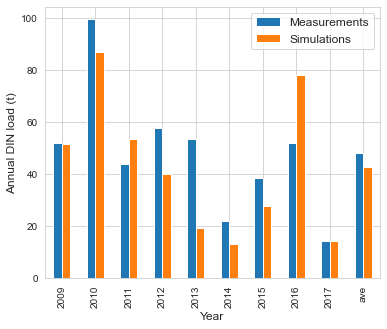

In [13]:
# sns.set_style('whitegrid')
# ax = df_month.plot(kind='bar', figsize=(6, 5), xlabel='Year', ylabel='Annual DIN load (t)', fontsize=10)
# ax.set_xlabel(ax.get_xlabel(), fontsize=12);
# ax.set_ylabel(ax.get_ylabel(), fontsize=12);
# # plt.xticks([i for i in range(0,df_month.shape[0], 6)], df_month.index[::6], rotation=45)
# plt.legend(['Measurements', 'Simulations'], fontsize=12);
# plt.savefig(f'{outpath}figs/mod_obs_annual_new_unit.png', format='png', dpi=300, layout='tight')

## Plot long term C-Q relationship

In [2]:
time_ranges = ['2009/7/1', '2014/6/30'] 
cols = day_load_flow.columns
day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


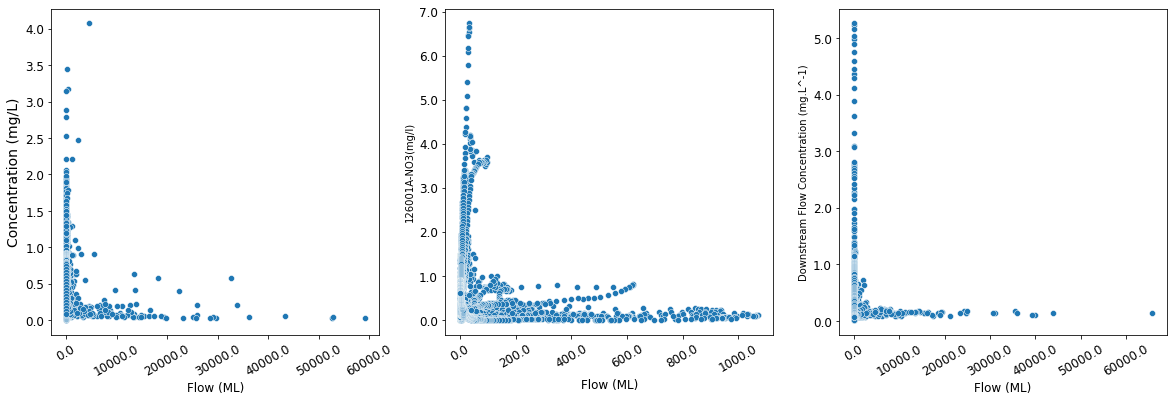

In [9]:
_, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=False, sharey=False)
start, end = pd.to_datetime(time_ranges)
# plot low-freq-obs in axes[0]
df_obs = load_flow_loc([start, end], day_load_flow, timestep ='d')
cols = day_load_flow.columns
sns.scatterplot(data=df_obs, x=cols[2], y=cols[3], ax=axes[0])

# plot high-freq-obs in axes[1]
df_obs_hour = load_flow_loc(['2018/7/1', '2020/6/30'], hour_load_flow, timestep ='h')
cols = hour_load_flow.columns
sns.scatterplot(data=df_obs_hour, x=cols[0], y=cols[1], ax=axes[1])

# plot mod in axes[1]
df_mod = load_flow_loc([start, end], mod_load_flow, timestep ='d')
cols = mod_load_flow.columns
sns.scatterplot(data=df_mod, x=cols[2], y=cols[1], ax=axes[2])
for ax in axes:
#     ax.set(xscale="log", yscale="log")
    ax.set_xticklabels(ax.get_xticks(), fontsize=12, rotation=30)
    ax.set_yticklabels(ax.get_yticks(), fontsize=12)
    ax.set_xlabel('Flow (ML)', fontsize=12)
axes[0].set_ylabel('Concentration (mg/L)', fontsize=14); #Load (kg) Concentration (mg/l)
# plt.savefig(f'{outpath}figs/obs_mod_longterm_load_flow.png', format='png', dpi=400, layout='tight')

## Calcluate the cumulative frequency distributions (CFD) of dissolved concentrations 

### Mod results

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


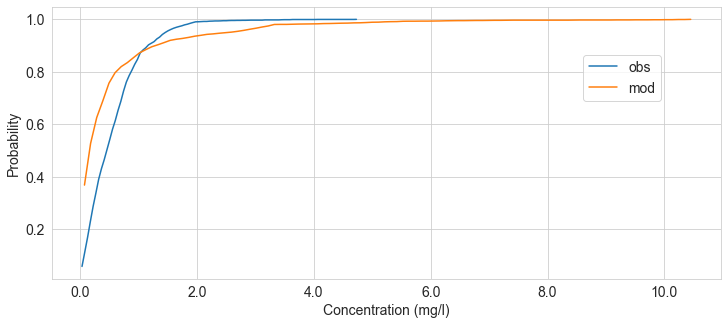

In [13]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1, 1, figsize=(12, 5), sharex=True, sharey=True) 
# Obs results
cols = day_load_flow.columns
time_ranges = [[f'{year}/7/1', f'{year+1}/6/30'] for year in range(2009, 2018)]
for tt in time_ranges:
    df = load_flow_loc(tt, day_load_flow, timestep='d')
df_temp = load_flow_loc([time_ranges[0][0], time_ranges[-1][1]], day_load_flow, timestep='d')
sns.histplot(data = df_temp, x=cols[-1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=ax);
# mod results
cols = mod_load_flow.columns
for tt in time_ranges:
    df = load_flow_loc(tt, mod_load_flow, timestep='d')
df_temp = load_flow_loc([time_ranges[0][0], time_ranges[-1][1]], mod_load_flow, timestep='d')
sns.histplot(data = df_temp, x=cols[1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=ax);

lgd = [*[year for year in range(2009, 2018)], 'all']
ax.set_xlabel('Concentration (mg/l)', fontsize=14);
ax.set_ylabel('Probability', fontsize=14);
ax.set_xticklabels(ax.get_xticks(), fontsize=14);
# axes[0].set_xlim(0, 10);
ax.set_yticklabels(np.round(ax.get_yticks(), 2), fontsize=14);

lgd = ['obs', 'mod']
plt.legend(lgd, bbox_to_anchor=(0.92, 0.85), fontsize=14)

# plt.savefig(f'{outpath}figs/obs_mod_concentration_cum_freq.png', format='png', dpi=400)

F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  app.launch_new_instance()
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
F:\Anaconda\envs\oed\lib\site-packages\ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


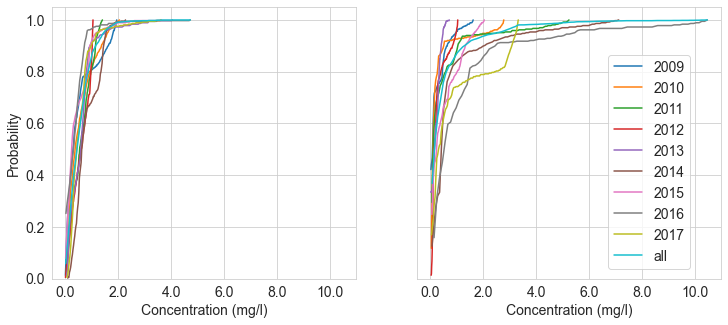

In [14]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True) 
# Obs results
cols = day_load_flow.columns
time_ranges = [[f'{year}/7/1', f'{year+1}/6/30'] for year in range(2009, 2018)]
for tt in time_ranges:
    df = load_flow_loc(tt, day_load_flow, timestep='d')
    ax = sns.histplot(data = df, x=cols[-1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=axes[0]);
df_temp = load_flow_loc([time_ranges[0][0], time_ranges[-1][1]], day_load_flow, timestep='d')
sns.histplot(data = df_temp, x=cols[-1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=axes[0]);
lgd = [*[year for year in range(2009, 2014)], 'all']
axes[0].set_xlabel('Concentration (mg/l)', fontsize=14);
axes[0].set_ylabel('Probability', fontsize=14);
axes[0].set_xticklabels(axes[1].get_xticks(), fontsize=14);
# axes[1].set_xlim(0, 10);
axes[0].set_yticklabels(np.round(axes[1].get_yticks(), 2), fontsize=14);


# mod results
cols = mod_load_flow.columns
time_ranges = [[f'{year}/7/1', f'{year+1}/6/30'] for year in range(2009, 2018)]

for tt in time_ranges:
    df = load_flow_loc(tt, mod_load_flow, timestep='d')
    sns.histplot(data = df, x=cols[1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=axes[1]);
df_temp = load_flow_loc([time_ranges[0][0], time_ranges[-1][1]], mod_load_flow, timestep='d')
sns.histplot(data = df_temp, x=cols[1],bins=100,cumulative=True, stat='probability', fill=False, element='poly', alpha=0.7, ax=axes[1]);
lgd = [*[year for year in range(2009, 2018)], 'all']
axes[1].set_xlabel('Concentration (mg/l)', fontsize=14);
axes[1].set_ylabel('Probability', fontsize=14);
axes[1].set_xticklabels(axes[0].get_xticks(), fontsize=14);
# axes[0].set_xlim(0, 10);
axes[1].set_yticklabels(np.round(axes[0].get_yticks(), 2), fontsize=14);


plt.legend(lgd, bbox_to_anchor=(0.92, 0.85), fontsize=14)

plt.savefig(f'{outpath}figs/obs_mod_concentration_cum_freq.png', format='png', dpi=400)

## Plot long term C distribution

In [66]:
time_ranges = ['2009/7/1', '2018/6/30'] 
cols = day_load_flow.columns
# day_load_flow[cols[0]] = day_load_flow[cols[0]] * 1000

In [68]:
day_load_flow.head()

,Linear_Average_Load(t),Flow (Cumecs),Flow(ML),Concentration (mg/L)
Date,,,,
2009-07-01,341.8,0.1985,17.15,0.019930
2009-07-02,453.0,0.2026,17.50,0.025886
2009-07-03,563.8,0.2052,17.73,0.031799
2009-07-04,566.5,0.1813,15.67,0.036152
2009-07-05,682.6,0.1994,17.23,0.039617


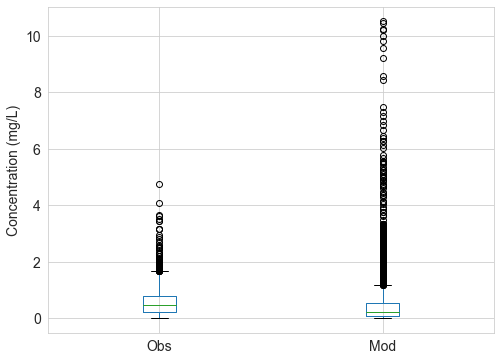

In [70]:
start, end = pd.to_datetime(time_ranges)
# plot obs in axes[0]
df_obs = load_flow_loc([start, end], day_load_flow, timestep ='d')
df_mod = load_flow_loc([start, end], mod_load_flow, timestep ='d')
df_plot = pd.concat([df_obs.filter(regex='Con', axis=1), df_mod.filter(regex='Co', axis=1)], axis=1)
ax = df_plot.boxplot(figsize = (8, 6), fontsize=14)

ax.set_xticklabels(['Obs', 'Mod'], fontsize=14)
ax.set_ylabel('Concentration (mg/L)', fontsize=14)
plt.savefig(f'{outpath}figs/obs_mod_concentration_boxplot.png', format='png', dpi=400)

## Plot Delivery Ratio Surface

In [7]:
df = pd.read_csv(outpath+'DeliveryRatioSurface.csv', index_col='month')
cols = df.columns

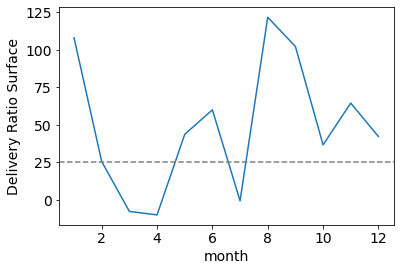

In [13]:
plt.rcParams.update({'font.size': 14})
ax = sns.lineplot(x=df.index, y=cols[-1], data=df);
ax.axhline(y=25, ls='--', color='grey',lw=1.5)
ax.set_ylabel('Delivery Ratio Surface')
plt.savefig(outpath+'figs/DeliveryRatioSurface.png', format='png', dpi=300)